# Import the libraries

In [2]:
from tensorflow import keras
import tensorflow as tf
from keras.models import Model
from keras import Input
from keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import graphviz
import sys
import os
import cv2
main_dir=os.path.dirname(sys.path[0])

# Data load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
train_imgs = sorted(os.listdir('drive/MyDrive/train'))
train_cleaned_imgs = sorted(os.listdir('drive/MyDrive/train_cleaned'))
test_imgs = sorted(os.listdir('drive/MyDrive/test'))

# Data preprocessing

In [6]:
train_img = cv2.imread('drive/MyDrive/train/101.png')
train_img_arr = np.asarray(train_img, dtype="float32")
train_resize_img = cv2.resize(train_img_arr, (540, 420))
normalize_train_imd = train_resize_img/255.0
train_reshape_img = np.reshape(normalize_train_imd, (420, 540,3))

In [7]:
train_cleaned_img = cv2.imread('drive/MyDrive/train_cleaned/101.png')
train_cleaned_img_arr = np.asarray(train_cleaned_img, dtype="float32")
train_cleaned_resize_img = cv2.resize(train_cleaned_img_arr, (540, 420))
normalize_train_cleaned_img = train_cleaned_resize_img/255.0
train_cleaned_reshape_img = np.reshape(normalize_train_cleaned_img, (420, 540,3))

In [8]:
test_img = cv2.imread('drive/MyDrive/test/1.png')
test_img_arr = np.asarray(test_img, dtype="float32")
test_resize_img = cv2.resize(test_img_arr, (540, 420))
normalize_test_imd = test_resize_img/255.0
test_reshape_img = np.reshape(normalize_test_imd, (420, 540,3))

In [9]:
train = []
train_cleaned = []
test = []

for i in train_imgs:
    train.append(train_reshape_img)

for i in train_cleaned_imgs:
    train_cleaned.append(train_cleaned_reshape_img)

for i in test_imgs:
    test.append(test_reshape_img)

# Split data

In [10]:
from sklearn.model_selection import train_test_split

X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned[1:])
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.15)

In [11]:
#--- Input Layer
visible = Input(shape=(420, 540, 3), name='Input-Layer') # Specify input shape

#--- Encoder Layer
e = Dense(units=420, name='Encoder-Layer')(visible)
e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
e = LeakyReLU(name='Encoder-Layer-Activation')(e)

#--- Middle Layer
middle = Dense(units=420, activation='linear', activity_regularizer=keras.regularizers.L1(0.0001), name='Middle-Hidden-Layer')(e)

#--- Decoder Layer
d = Dense(units=420, name='Decoder-Layer')(middle)
d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
d = LeakyReLU(name='Decoder-Layer-Activation')(d)

#--- Output layer
output = Dense(units=3, activation='sigmoid', name='Output-Layer')(d)

# Define denoising autoencoder model
model = Model(inputs=visible, outputs=output, name='Denoising-Autoencoder-Model')

# Compile denoising autoencoder model
model.compile(optimizer='adam', loss='mse')

# Print model summary
print(model.summary())

Model: "Denoising-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 420, 540, 3)]     0         
                                                                 
 Encoder-Layer (Dense)       (None, 420, 540, 420)     1680      
                                                                 
 Encoder-Layer-Normalization  (None, 420, 540, 420)    1680      
  (BatchNormalization)                                           
                                                                 
 Encoder-Layer-Activation (L  (None, 420, 540, 420)    0         
 eakyReLU)                                                       
                                                                 
 Middle-Hidden-Layer (Dense)  (None, 420, 540, 420)    176820    
                                                                 
 Decoder-Layer (Dense)       (None, 420

Epoch 1/20
61/61 [==============================] - 1218s 20s/step - loss: 279.6978 - val_loss: 84.4744
Epoch 2/20
61/61 [==============================] - 1211s 20s/step - loss: 64.6095 - val_loss: 91.3588
Epoch 3/20
61/61 [==============================] - 1222s 20s/step - loss: 61.1265 - val_loss: 108.2773
Epoch 4/20
61/61 [==============================] - 1221s 20s/step - loss: 55.2199 - val_loss: 135.9588
Epoch 5/20
61/61 [==============================] - 1225s 20s/step - loss: 51.6156 - val_loss: 167.2036
Epoch 6/20
61/61 [==============================] - 1210s 20s/step - loss: 45.4668 - val_loss: 221.1472
Epoch 7/20
61/61 [==============================] - 1203s 20s/step - loss: 42.3927 - val_loss: 259.2324
Epoch 8/20
61/61 [==============================] - 1203s 20s/step - loss: 39.0344 - val_loss: 341.7088
Epoch 9/20
61/61 [==============================] - 1202s 20s/step - loss: 34.6302 - val_loss: 444.6306
Epoch 10/20
61/61 [==============================] - 1218s 20s/st

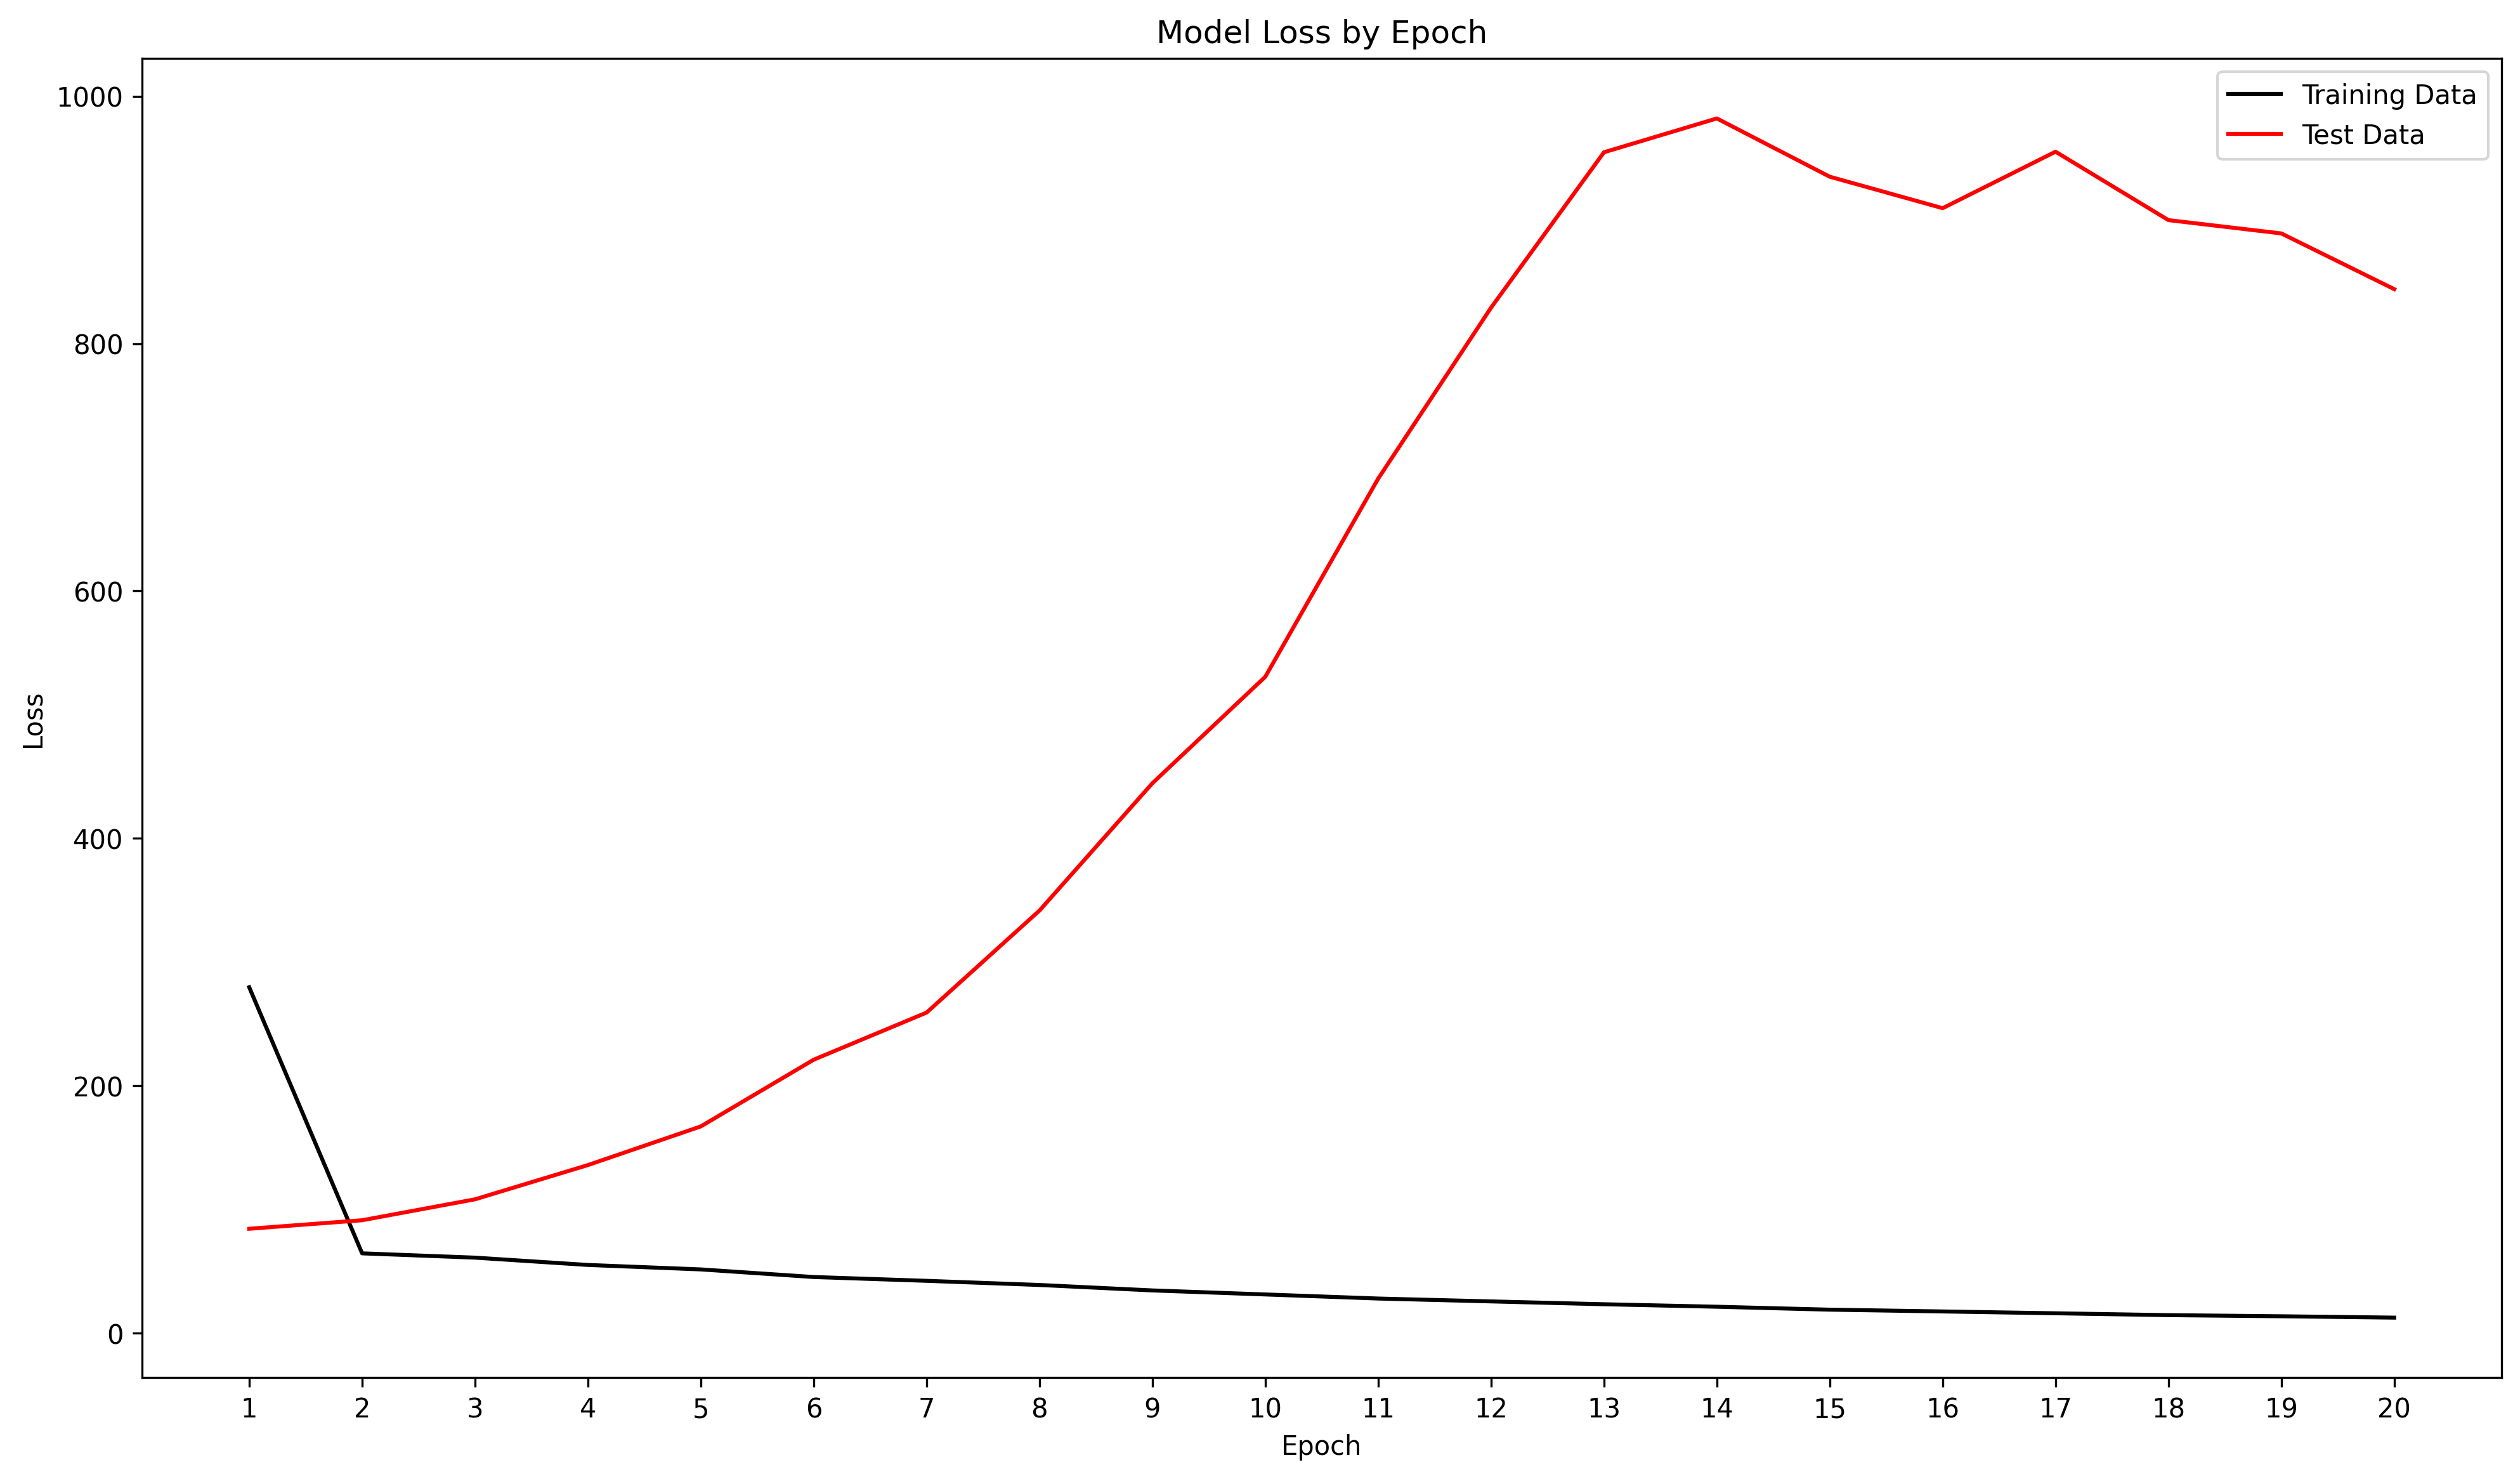

In [12]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=2, verbose=1, validation_data=(X_val, Y_val))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
plt.legend()

plt.show()